---
# 0. 라이브러리
----

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from torchvision import transforms, datasets

from PIL import Image
from pprint import pprint
import easydict

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # GPU 할당

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import librosa
from collections import Counter

In [2]:
cd /content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/

/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data


---
# 1. Data
----

In [3]:
class Config():
  train = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/train.csv'
  test = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/test.csv'
  sub = '/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/sample_submission.csv'
  epoch = 100
  num_worker = 5
  lr = 1e-4
  sr = 16000
  batch_size = 64


config = Config()

In [4]:
train = pd.read_csv(config.train)
test = pd.read_csv(config.test)
train

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE,LABEL
0,TRAIN_0000,./train/TRAIN_0000.wav,2,0
1,TRAIN_0001,./train/TRAIN_0001.wav,0,0
2,TRAIN_0002,./train/TRAIN_0002.wav,0,0
3,TRAIN_0003,./train/TRAIN_0003.wav,2,0
4,TRAIN_0004,./train/TRAIN_0004.wav,2,0
...,...,...,...,...
1274,TRAIN_1274,./train/TRAIN_1274.wav,2,0
1275,TRAIN_1275,./train/TRAIN_1275.wav,2,0
1276,TRAIN_1276,./train/TRAIN_1276.wav,2,0
1277,TRAIN_1277,./train/TRAIN_1277.wav,2,0


---
# 2. Preprocessing
---

- Positive FFT
  - 신호의 양의 주파수 성분만 반환하는 FFT 알고리즘의 변형

  - 0Hz 보다 큰 주파수이며 신호 주파수 스팩트럼의 오른쪽 절반에 해당함

  - 양의 주파수 성분만 관심있는 오디오 신호 처리에 유용

- np.linespace 

  - 지정된 간격에 걸쳐 균등하게 간격을 둔 샘플의 1D 배열을 생성
  - Start : 시퀀스의 시작 값
  - Stop : 시퀀스의 끝 값
  - Num : 생성할 샘플 수 
  - endpoint 빈도 값 범위에 대한 앤드포인트 포함 여부

- Y =2*np.abs(Y[0:N])/(L/2)

  - 먼저 Y[0:N]는 양의 주파수 성분에 해당하는 FFT의 첫 번째 N개 값만 선택하는 데 사용

  - np.abs(Y[0:N])를 사용하여 양의 주파수 성분의 크기를 반환하는 복소수의 절대값 계산

  - 2*np.abs(Y[0:N])를 사용하여 양의 주파수 성분의 크기를 2배로 조정

  - FFT가 양변 스펙트럼을 반환하기 때문에 즉, 음의 주파수가 원점 주위에 반사되기 때문  
    따라서 양 및 음의 주파수 성분은 중복되며 원래 신호의 최대 두 배의 에너지를 합하게 됨

  - 마지막으로 /(L/2)는 신호의 길이만큼 양의 주파수 성분을 정규화하는 데 사용   
    이는 양의 주파수 성분의 진폭이 원래 신호의 에너지를 반영하도록 하기 위해 수행

최종 결과물은 정확한 진폭과 에너지 표현으로 양의 주파수 성분을 반환하는 것     

In [5]:
# FFT Code
def PositiveFFT(Input_rawdata,Sampling_frequency=16000, Length=16000):

    
    Fs = Sampling_frequency  # 시간 단위로 수집되는 신호의 샘플 수 / 높을수록 더 많은 샘플을 추출해 고해상도 디지털 신호가 생성되나 계산비용의 증가됨
    
    Input_rawdata = np.hanning(Length)*Input_rawdata # hanning window 적용 
                                                     # 스펙트럼의 누출을 줄이고 신호의 주파수 영역표현을 정확하게 하기 위해 사용
    L = len(Input_rawdata)  # 신호의 전체 길이
    
    X = Input_rawdata
    Y = np.fft.fft(X)  # 신호의 전체 FFT 반환
    
    N = int(len(Y)/2)
    Y =2*np.abs(Y[0:N])/(L/2) # FFT의 양의 주파수 성분만 선택 

    freq = np.linspace(0, Fs/2, N, endpoint=True) # FFT의 주파수의 배열인 freq를 생성하고 FFT와 주파수를 튜플로 반환
                                                  # 양의 주파수 성분에 해당하는 주파수 값 배열을 생성
    return (Y,freq)

In [6]:
def FFT_Result(Data):
    
    STRIDE=16000 # 한 번에 입력 신호에서 추출할 샘플 수를 정의
    Fs=16000 # 샘플링 주파수 
    
    sample = [Data[i:i+Fs] for i in range(0, len(Data), STRIDE)] 

    # 주파수 및 진폭의 값을 저장하는 리스트 생성
    F=[]
    A=[]
    for samp in sample:
        y, freq = PositiveFFT(samp) # 진폭 값, 주파수 값 반환
        A.append(y)
    
    F=freq
    A=np.array(A).mean(axis=0) # 모든 진폭값의 평균 계산 
    
    return F, A # 지정된 입력 신호에 대한 FFT의 주파수 및 진폭 값 반환

In [7]:
def get_feature(df):
    features = []
    for path in tqdm(df['SAMPLE_PATH']):
        # librosa패키지를 사용하여 wav 파일 load
        wav, sr = librosa.load(path, sr=config.sr)
        f, y = FFT_Result(wav)
        features.append(y)
    return np.array(features)

In [8]:
X_train=get_feature(train)
X_test=get_feature(test)

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1514 [00:00<?, ?it/s]

---
# 3. Dataset & DataLoader
---

In [9]:
class custom_dataset(Dataset):
  
  def __init__(self, data):

    self.data = data

  def __len__(self):
    return len(self.data)
    

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.data[idx])
    return x


In [10]:
train_dataset = custom_dataset(X_train)
train_loader = DataLoader(dataset = train_dataset, batch_size = config.batch_size, shuffle = True, drop_last = False)

test_dataset = custom_dataset(X_test)
test_loader = DataLoader(dataset = test_dataset, batch_size = config.batch_size, shuffle = False, drop_last = False)

---
# 4. Model
----

In [11]:
class Auto_Encoder(nn.Module):

  def __init__(self):
    super(Auto_Encoder, self).__init__()

    self.fc_encoder = nn.Sequential(
                              nn.Linear(8000, 4000, bias = False),
                              nn.Linear(4000, 2000, bias = False),
                              nn.Linear(2000, 1000, bias = False),
                              nn.Linear(1000, 200, bias = True),
                                  )
    
    self.fc_decoder = nn.Sequential(
                              nn.Linear(200, 1000, bias = True),
                              nn.Linear(1000, 2000, bias = False),
                              nn.Linear(2000, 4000, bias = False),
                              nn.Linear(4000, 8000, bias = False),                                         
                                  )
    

  def forward(self, x):

    en = self.fc_encoder(x)
    de = self.fc_decoder(en)

    return de, en


- MSE는 이상치에 대해 너무 민감하여, 모델의 학습을 불안정하게 만들 가능성이 크다. 

- 현실 세계에서 마주하는 많은 데이터에는 이상치가 있고, 그 중 어떤 경우에 이상치가 처리되지 않을 때가 있는데, 그러한 경우 MSE를 이용한다면, 이상치에 민감하게 학습되기 때문에 학습 과정이 불안정할 것이다. 

- 이 불안정함은 결국 모델의 피팅fitting을 방해하여 목적에 맞는 좋은 성능의 모델을 얻는 데 악영향을 끼칠 것이다.

- 그렇다면, MSE에 루트를 취하여 이상치에 대한 민감도를 줄인 RMSE와 절대값을 취하는 MAE 는 어떤 차이가 있는가? 

- MAE는 오차들의 절댓값의 평균을 계산한다는 점에서, 모든 examples에 대한 오차에 동일한 가중치를 부여한다. 
- 반면에, RMSE는 각 example에 제곱을 취한 뒤 평균을 구하고, 그것에 루트를 씌우는 것이기 때문에, 각 오차가 다른 가중치를 갖는다.


이전 MSE를 사용했을 때, 결과값이 안 좋았기에 MAE인 nn.L1Loss를 사용하게 되었고 결과값 또한 더 좋다.

In [12]:
model = Auto_Encoder().to(device)
loss_function = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr = config.lr)

In [13]:
for i in train_loader:
  print(i.shape)
  break

torch.Size([64, 8000])


---
# 5. Train
---

In [14]:
graph_loss = []

for epoch in range(config.epoch):
  
  train_loss = 0
  model.train()

  for num, i in enumerate(tqdm(train_loader)):
    i = i.to(device)

    decoder,_ = model(i)
    loss = loss_function(i, decoder)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  graph_loss.append(train_loss)
  print(f'EPOCH : {epoch + 1}, TRAIN_LOSS : {train_loss / len(train_loader.dataset)}')
  

  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 1, TRAIN_LOSS : 1.63024126921953e-05


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 2, TRAIN_LOSS : 2.3497677183064886e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 3, TRAIN_LOSS : 1.6219881920259012e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 4, TRAIN_LOSS : 1.3953059999289703e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 5, TRAIN_LOSS : 1.3521206770452691e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 6, TRAIN_LOSS : 1.3123163875600903e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 7, TRAIN_LOSS : 1.2831896426723404e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 8, TRAIN_LOSS : 1.225600631574811e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 9, TRAIN_LOSS : 1.2138559048095363e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 10, TRAIN_LOSS : 1.1819898728113781e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 11, TRAIN_LOSS : 1.1753425090114984e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 12, TRAIN_LOSS : 1.1416791618854081e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 13, TRAIN_LOSS : 1.1447788392935615e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 14, TRAIN_LOSS : 1.1274147636029196e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 15, TRAIN_LOSS : 1.0997877363679878e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 16, TRAIN_LOSS : 1.1047021821002892e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 17, TRAIN_LOSS : 1.0859789415987164e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 18, TRAIN_LOSS : 1.0648658249270173e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 19, TRAIN_LOSS : 1.0686668215928988e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 20, TRAIN_LOSS : 1.053593335685956e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 21, TRAIN_LOSS : 1.0380494156000412e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 22, TRAIN_LOSS : 1.0362561110664157e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 23, TRAIN_LOSS : 9.979805804878631e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 24, TRAIN_LOSS : 1.0066679430371143e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 25, TRAIN_LOSS : 1.009162430297598e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 26, TRAIN_LOSS : 9.860689646447554e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 27, TRAIN_LOSS : 1.0034522655885303e-06


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 28, TRAIN_LOSS : 9.931871921269687e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 29, TRAIN_LOSS : 9.861429444655478e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 30, TRAIN_LOSS : 9.853436358646577e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 31, TRAIN_LOSS : 9.631361446268361e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 32, TRAIN_LOSS : 9.542730810698501e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 33, TRAIN_LOSS : 9.563220026804553e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 34, TRAIN_LOSS : 9.592215713434666e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 35, TRAIN_LOSS : 9.464120346342124e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 36, TRAIN_LOSS : 9.462202372057822e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 37, TRAIN_LOSS : 9.278086170374304e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 38, TRAIN_LOSS : 9.187334556182798e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 39, TRAIN_LOSS : 9.187676793563619e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 40, TRAIN_LOSS : 9.031381145934483e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 41, TRAIN_LOSS : 9.080064185804733e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 42, TRAIN_LOSS : 8.863113732080822e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 43, TRAIN_LOSS : 8.846931496044901e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 44, TRAIN_LOSS : 8.690793427794901e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 45, TRAIN_LOSS : 8.74293712700482e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 46, TRAIN_LOSS : 8.566749955597025e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 47, TRAIN_LOSS : 8.56682055343439e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 48, TRAIN_LOSS : 8.502133535645375e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 49, TRAIN_LOSS : 8.350984760488371e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 50, TRAIN_LOSS : 8.215207967541651e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 51, TRAIN_LOSS : 8.214742511050649e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 52, TRAIN_LOSS : 8.243409044508319e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 53, TRAIN_LOSS : 8.184642687897206e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 54, TRAIN_LOSS : 8.063441845300761e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 55, TRAIN_LOSS : 7.928083263475235e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 56, TRAIN_LOSS : 7.939341200801068e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 57, TRAIN_LOSS : 7.787848225631987e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 58, TRAIN_LOSS : 7.84073189371342e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 59, TRAIN_LOSS : 7.776023514532033e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 60, TRAIN_LOSS : 7.806839043883632e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 61, TRAIN_LOSS : 7.708282955391354e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 62, TRAIN_LOSS : 7.545717184444958e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 63, TRAIN_LOSS : 7.440436097286842e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 64, TRAIN_LOSS : 7.526872112897047e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 65, TRAIN_LOSS : 7.368148036193367e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 66, TRAIN_LOSS : 7.340300403516434e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 67, TRAIN_LOSS : 7.315672595413261e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 68, TRAIN_LOSS : 7.247380679109198e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 69, TRAIN_LOSS : 7.208560600844405e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 70, TRAIN_LOSS : 7.125739609788772e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 71, TRAIN_LOSS : 7.043901697885058e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 72, TRAIN_LOSS : 6.943060509287814e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 73, TRAIN_LOSS : 6.899846867626158e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 74, TRAIN_LOSS : 6.898122397406163e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 75, TRAIN_LOSS : 6.723765877413726e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 76, TRAIN_LOSS : 6.814141690385534e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 77, TRAIN_LOSS : 6.695550578481432e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 78, TRAIN_LOSS : 6.622896443992748e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 79, TRAIN_LOSS : 6.653647462508267e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 80, TRAIN_LOSS : 6.484076833056448e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 81, TRAIN_LOSS : 6.460708948888068e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 82, TRAIN_LOSS : 6.425477186326401e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 83, TRAIN_LOSS : 6.421340329409085e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 84, TRAIN_LOSS : 6.403915036689604e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 85, TRAIN_LOSS : 6.319470750477436e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 86, TRAIN_LOSS : 6.219064242037579e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 87, TRAIN_LOSS : 6.204544240900077e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 88, TRAIN_LOSS : 6.0532197391358e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 89, TRAIN_LOSS : 6.110303267442269e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 90, TRAIN_LOSS : 6.025528036089989e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 91, TRAIN_LOSS : 5.981901616098009e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 92, TRAIN_LOSS : 5.910044025460096e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 93, TRAIN_LOSS : 5.931078255732862e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 94, TRAIN_LOSS : 5.82093265900815e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 95, TRAIN_LOSS : 5.758698901845663e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 96, TRAIN_LOSS : 5.701219434016169e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 97, TRAIN_LOSS : 5.716319719795138e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 98, TRAIN_LOSS : 5.66769604240941e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 99, TRAIN_LOSS : 5.60864299941521e-07


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH : 100, TRAIN_LOSS : 5.542045203656499e-07


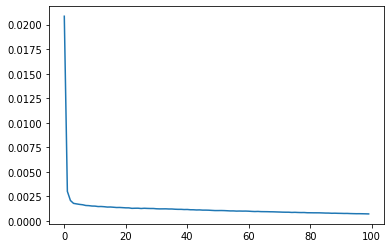

In [15]:
plt.plot(graph_loss)

---
# 6. Prediction
----

In [16]:
def eval(model, dataloader):
  scores = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(dataloader):
      i = i.to(device)
      de, en = model(i)
      score = torch.mean(torch.abs(i - de), axis = 1)
      scores.extend(score.cpu().numpy())

  return np.array(scores)


In [17]:
train_scores = eval(model, train_loader)
test_scores = eval(model, test_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [18]:
threshold = train_scores.max()
threshold

3.6366066e-05

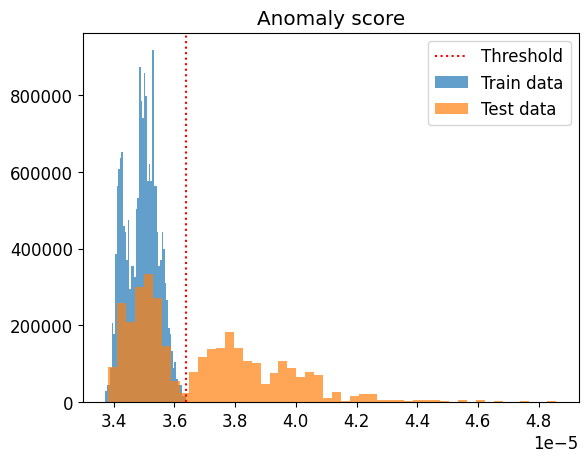

In [19]:
# 히스토그램
plt.style.use('default')
plt.rcParams['font.size'] = 12

plt.hist(train_scores, bins=50, density=True, alpha=0.7, label='Train data')
plt.hist(test_scores, bins=50, density=True, alpha=0.7, label='Test data')
plt.axvline(x=threshold, c='red', linestyle=':', label='Threshold')
plt.title("Anomaly score")
plt.legend()

In [20]:
def get_pred_label(model_pred, t):
    # IsolationForest 모델 출력 (1:정상, -1:불량) 이므로 (0:정상, 1:불량)로 Label 변환
    model_pred = np.where(model_pred <= t, 0, model_pred)
    model_pred = np.where(model_pred > t, 1, model_pred)
    return model_pred

In [21]:
train_pred = get_pred_label(train_scores, threshold)
Counter(train_pred)

Counter({0.0: 1279})

In [22]:
test_pred = get_pred_label(test_scores, threshold)
Counter(test_pred)

Counter({0.0: 751, 1.0: 763})

---
# 7. Submisson
---

In [23]:
sub = pd.read_csv(config.sub)
sub['LABEL'] = test_pred
sub

,SAMPLE_ID,LABEL
0,TEST_0000,0.0
1,TEST_0001,0.0
2,TEST_0002,1.0
3,TEST_0003,1.0
4,TEST_0004,1.0
...,...,...
1509,TEST_1509,1.0
1510,TEST_1510,1.0
1511,TEST_1511,0.0
1512,TEST_1512,0.0


In [24]:
sub.to_csv('/content/drive/MyDrive/2. Study/DACON/기계_고장_진단_AI_경진대회/data/sub_0127(1).csv', index = False)